# Preprocesamiento de imágenes para la industria

Empezamos importando las librerías y cargando los datos de entrenamiento y de prueba:

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('./data/train_ships.json') as json_data:
    train_d = json.load(json_data)

In [3]:
with open('./data/test_ships.json') as json_data:
    test_d = json.load(json_data)

Ahora, cada una de las imágenes viene en una lista plana de tamaño 19200 que corresponde a una imagen de 80x80 y los 3 canales (RGB).
Los primeros 6400 datos corresponden a el canal R, los siguientes 6400 al G y los últimos al B. Por esta razón debemos reformar la lista
en algo que nuestro modelo pueda interpretar como imágenes.

In [9]:
def reshape_data(dictionary):
    data = []
    for fimg in dictionary['data']:
        data.append(np.array([[fimg[ii],fimg[ii+6400],fimg[ii+12800]] for ii in range(6400)], dtype=np.uint8).reshape([80,80,3]))
    return np.array(data, dtype=np.uint8), np.array(dictionary['labels'], dtype=np.uint8)

In [7]:
train_images, train_labels = reshape_data(train_d)
test_images, test_labels = reshape_data(test_d)

Esta imagen no tiene un barco


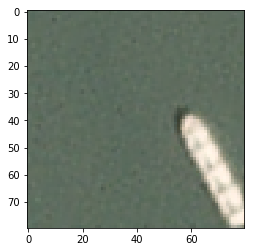

In [33]:
ii = 26
print(f"Esta imagen {'sí' if train_labels[ii] else 'no'} tiene un barco")
plt.imshow(train_images[ii])

In [30]:
# TODO: Acá realicen todas las transformaciones que quieran con las imágenes. Ya sea para cambiar el set de datos o para aumentarlo

## Definición del modelo (CNN)

In [21]:
import tensorflow as tf

In [22]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
#num_input = 4000 
num_classes = 2
dropout = 0.4

In [23]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [25]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [26]:
def train(train_data, train_labels, test_data, test_labels, num_steps=2000):
    # Build the Estimator
    model = tf.estimator.Estimator(model_fn)

    # Define the input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': train_data}, y=np.array(train_labels),
        batch_size=batch_size, num_epochs=None, shuffle=True)
    # Train the Model
    model.train(input_fn, steps=num_steps)

    # Evaluate the Model
    # Define the input function for evaluating
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': test_data}, y=test_labels,
        batch_size=batch_size, shuffle=False)
    # Use the Estimator 'evaluate' method
    e = model.evaluate(input_fn)

    print("Testing Accuracy:", e['accuracy'])

In [29]:
train(np.array(train_images, dtype=np.float32), train_labels, np.array(test_images, dtype=np.float32), test_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/jl/pc72bld16gn0mlgq604hqjt00000gn/T/tmphcd0i8w4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x161bc9c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec